In [1]:
import ctypes
import binascii
import typing
import math
import datetime
import enum
import io
from types import SimpleNamespace
from pathlib import Path

import trio
import xarray as xa
import trio_serial
import anyio
import tqdm.notebook
import matplotlib.pyplot as plt
import serial.tools.list_ports
from IPython import display
import ipywidgets 
import bokeh.io
import bokeh.plotting
import bokeh.layouts
import bokeh as bk
import crcmod
import numpy as np
import scipy.ndimage
import scipy.stats
import scipy.optimize
import pandas as pd
import attrs
import contextlib
import pint
import pint_pandas
import numba
import jax
import jax.numpy as jnp
import cbor2

import jax
jax.config.update('jax_platform_name', 'cpu')

from epymetrics.units import u, pandas_units

bk.io.output_notebook()
%matplotlib inline
%autoawait trio

Loading BokehJS ...

In [2]:
class Protocol(enum.IntEnum):
    hdr = 0x54
    data = 0x2c
    health = 0xe0
    mfg = 0x0f

ct = ctypes

class Point(ct.LittleEndianStructure):
    _pack_ = 1
    _fields_ = tuple(dict(
        distance = ct.c_uint16,   # [mm]
        intensity = ct.c_uint8,
    ).items())
    
class Data(ct.LittleEndianStructure):
    _pack_ = 1
    _fields_ = tuple(dict(
        speed = ct.c_uint16,      # [°/s]
        start_angle = ct.c_uint16, # [0.01°]
        points = Point*12,
        end_angle = ct.c_uint16,  # [0.01°]
        timestamp = ct.c_uint16,  # [ms]; 30'000 wrapping
    ).items())

    
class HealthData(ct.LittleEndianStructure):
    _pack_ = 1
    _fields_ = tuple(dict(
        error_code = ct.c_uint8,
    ).items())


class MfgData(ct.LittleEndianStructure):
    _pack_ = 1
    _fields_ = tuple(dict(
        speed = ct.c_uint16,
        product_version = ct.c_uint16,
        sn_high = ct.c_uint32,
        sn_low = ct.c_uint32,
        hardware_version = ct.c_uint32,
        software_version = ct.c_uint32,
    ).items())


packet_types = {
    Protocol.data: Data,
    Protocol.health: HealthData,
    Protocol.mfg: MfgData,
}

crcfun = crcmod.Crc(poly=0x14d,initCrc=0,xorOut=False,rev=False)
def calc_crc(data):
    return crcfun.new(data).crcValue

async def stream_points(ser):
    buf = b""
    while True:
        d = await ser.receive_some()
        if not d:
            break
        buf += d
        data = []
        while True:
            hdr = buf.find(Protocol.hdr)
            if hdr < 0:
                buf = b""
                break
            buf = buf[hdr:]
            if len(buf)<2:
                break
            try:
                cmd = Protocol(buf[1])
            except ValueError:
                # skip header of packet that we don't know and try again
                buf = buf[1:]
                continue
            ptype = packet_types.get(cmd)
            if ptype is None:
                # skip header of packet that we don't know and try again
                buf = buf[1:]
                continue
            sz = ctypes.sizeof(ptype)
            if len(buf)<sz+3:
                break
            expected = buf[sz+2]
            actual = calc_crc(buf[:sz+2])
            if actual != expected:
                print(f"CRC mismatch for packet {cmd}: expected 0x{expected:02x}, got 0x{actual:02x}")
                # skip header of corrupt packet, then try again
                buf = buf[1:]
                continue
            msg = ptype.from_buffer_copy(buf[2:sz+2])
            data.append(msg)
            buf = buf[sz+3:]
        if data:
            yield data
        

In [3]:
@attrs.mutable(kw_only=True)
class FileStream:
    fpath: Path
    block_size: int = 2**14
    delay: float | None = None
    _stack: contextlib.AsyncExitStack | None = None
    _fh: typing.Any = None

    async def __aenter__(self):
        async with contextlib.AsyncExitStack() as stack:
            self._fh = await stack.enter_async_context(await trio.open_file(self.fpath,"rb"))
            self._stack = stack.pop_all()
        return self

    async def __aexit__(self, typ, exc, tb):
        return await self._stack.__aexit__(typ, exc, tb)


    async def receive_some(self):
        ret = await self._fh.read(2**14)
        if self.delay is not None:
            await trio.sleep(self.delay)
        return ret
            


In [4]:
@attrs.mutable(kw_only=True)
class CBORFileStream:
    fpath: Path
    delay: float | None = None
    control_history: list = attrs.field(factory=list)
    last_read_ts: float | None = None
    next_read_ts: float | None = None
    _pending: list = attrs.field(factory=list)
    _fh: io.BytesIO | None = None

    async def __aenter__(self):
        async with await trio.open_file(self.fpath, "rb") as fh:
            data = await fh.read()
            self._fh = io.BytesIO(data)
        return self

    async def __aexit__(self, typ, exc, tb):
        self._fh = None


    async def receive_some(self):
        while not self._pending:
            data = cbor2.load(self._fh)
            if self.delay is not None:
                await trio.sleep(self.delay)
            self.control_history.extend(data["control"])
            self._pending.extend(data["lidar"])
        self.last_read_ts = self.next_read_ts
        self.next_read_ts, data = self._pending.pop(0)
        return data
            


In [5]:
fig = bk.plotting.figure(match_aspect=True)

ds = bk.models.ColumnDataSource(data=dict(x=[],y=[],i=[]))

fig.scatter(x="x",y="y",size="i",source=ds)
r = 4000
fig.x_range.start = -r
fig.x_range.end = r
fig.y_range.start = -r
fig.y_range.end = r

hdl = bk.io.show(fig, notebook_handle=True)
alldata = []
tlp = trio.current_time()
async with CBORFileStream(fpath="../run1.cbor",delay=0.1) as ser:
    r,i,p = [],[],[]
    async for data in stream_points(ser):
        for d in data:
            sa = d.start_angle
            da = (d.end_angle - d.start_angle) % 36000
            ea = sa + da
            p.extend(np.linspace(sa,ea,len(d.points))*-np.pi/18000)
            i.extend(p.intensity for p in d.points)
            r.extend(p.distance for p in d.points)
        now = trio.current_time()
        if now < tlp+0.1:
            continue
        tlp = now
        r,i,p = (np.array(v) for v in (r,i,p))
        x,y = np.array([np.cos(p),np.sin(p)])*r
        ds.stream(dict(x=x,y=y,i=i*0.02),rollover=600)
        r,i,p = [],[],[]
        bk.io.push_notebook(handle=hdl)

KeyboardInterrupt: 

In [6]:
async with CBORFileStream(fpath=Path("../run1.cbor").resolve(),delay=0.1) as ser:
    totsz = ser.fpath.stat().st_size
    pbar = tqdm.notebook.tqdm(total=totsz)
    prev = 0 
    n = 0
    alldata = []
    lts = None
    offs = 0
    try:
        async for data in stream_points(ser):
            r,i,p,t,rt = [],[],[],[],[]
            for d in data:
                sa = d.start_angle
                da = (d.end_angle - d.start_angle) % 36000
                ea = sa + da
                p.extend(np.linspace(sa,ea,len(d.points))*-np.pi/18000)
                i.extend(p.intensity for p in d.points)
                r.extend(p.distance for p in d.points)
                if lts is not None and d.timestamp < lts:
                    offs += 30000
                t.append(d.timestamp + offs)
                rt.append((ser.last_read_ts,ser.next_read_ts))
                lts = d.timestamp
            r,i,p = (np.array(v).reshape(-1,12) for v in (r,i,p))
            t = np.array(t)
            rt = np.array(rt)
            alldata.append((t,r,i,p,rt))
            # progress
            cur = ser._fh.tell()
            pbar.update(cur-prev)
            prev = cur
            n += t.size
            pbar.set_postfix(n=n)
    except Exception as ex:
        print(f"Failed: {ex!r}")

ts = xa.DataArray(
    np.concatenate([d[0] for d in alldata])*0.001,
    dims = ("ts",)
)
reftime = xa.DataArray(
    np.concatenate([d[4] for d in alldata]),
    dims = ("ts","bound"),
    coords = dict(bound=["early","late"]),
)

crt_early,crt_late = np.array([v[:2] for v in ser.control_history]).T
cinp = np.array([v[2:] for v in ser.control_history])

control = xa.DataArray(
    data = cinp,
    dims = ["ts","ctype"],
    coords = dict(
        ctype = ["speed","steer"],
    )
)
n = control.shape[0]
startoffset = reftime.isel(ts=0) - ts.isel(ts=0)
control = xa.concat([
    control[np.maximum(0,np.searchsorted(crt_late,startoffset.sel(bound="early")+ts)-1)],
    control[np.maximum(0,np.searchsorted(crt_early,startoffset.sel(bound="late")+ts)-1)],
], dim="bound").transpose("ts","bound","ctype")

trace = xa.Dataset(
    data_vars = dict(
        distance = (("ts","col"),np.concatenate([d[1] for d in alldata],axis=0)*0.001),
        intensity = (("ts","col"),np.concatenate([d[2] for d in alldata],axis=0)/255),
        phi = (("ts","col"),np.concatenate([d[3] for d in alldata],axis=0)),
        control = control,
    ),
    coords = dict(
        ts=ts,
        bound=["early","late"],
        reftime=reftime,
    ),
)
trace 

  0%|          | 0/8320535 [00:00<?, ?it/s]

CRC mismatch for packet 44: expected 0x51, got 0x29
CRC mismatch for packet 44: expected 0x4a, got 0x91
CRC mismatch for packet 44: expected 0x03, got 0x54
CRC mismatch for packet 44: expected 0xb7, got 0xaa
CRC mismatch for packet 44: expected 0xd9, got 0x43
CRC mismatch for packet 44: expected 0xff, got 0xe0
CRC mismatch for packet 44: expected 0xff, got 0xec
CRC mismatch for packet 44: expected 0x46, got 0xcb
CRC mismatch for packet 44: expected 0x09, got 0x13
CRC mismatch for packet 44: expected 0xff, got 0xce
CRC mismatch for packet 44: expected 0xf4, got 0xcf
CRC mismatch for packet 44: expected 0x54, got 0xc1
CRC mismatch for packet 44: expected 0x42, got 0x90
CRC mismatch for packet 44: expected 0x4f, got 0x31
CRC mismatch for packet 44: expected 0xc6, got 0x1b
CRC mismatch for packet 44: expected 0x3e, got 0x27
CRC mismatch for packet 44: expected 0x0e, got 0x4c
CRC mismatch for packet 44: expected 0xe4, got 0x17
CRC mismatch for packet 44: expected 0xff, got 0x1d
CRC mismatch

<xarray.Dataset> Size: 61MB
Dimensions:    (ts: 176194, col: 12, ctype: 2, bound: 2)
Coordinates:
  * ctype      (ctype) <U5 40B 'speed' 'steer'
  * bound      (bound) <U5 40B 'early' 'late'
  * ts         (ts) float64 1MB 12.37 12.37 12.37 12.38 ... 438.7 438.7 438.7
    reftime    (ts, bound) float64 3MB 92.79 93.04 92.79 ... 599.1 598.9 599.1
Dimensions without coordinates: col
Data variables:
    distance   (ts, col) float64 17MB 1.854 1.853 1.84 ... 1.181 1.187 1.192
    intensity  (ts, col) float64 17MB 0.1333 0.2353 0.1725 ... 0.1804 0.1686
    phi        (ts, col) float64 17MB -2.448 -2.46 -2.473 ... -1.851 -1.863
    control    (ts, bound, ctype) int64 6MB 0 10 0 10 0 10 0 ... 3 0 3 0 3 0 3

(array([ 69665.,  66326.,  81542.,  97429., 126989., 169503., 168120.,
        198804., 278912., 857038.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

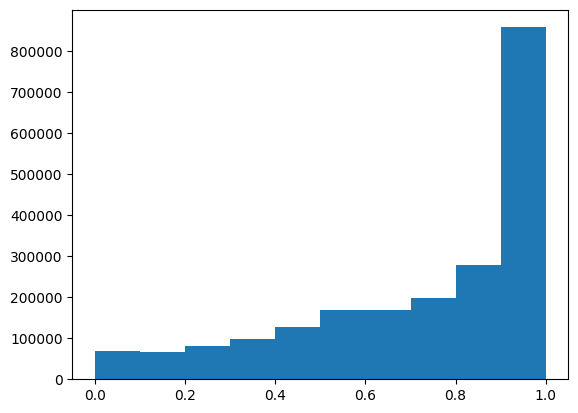

In [46]:
plt.hist(trace.intensity.to_numpy().ravel())

In [7]:
@numba.njit
def render_lidar(shape, pos, angle, distance, pconf, nconf):
    """ Count cell hits using Bresenham's. """
    n = pos.shape[0]
    assert pos.shape == (n,2) # x,y
    assert angle.shape == (n,)
    assert distance.shape == (n,)
    assert pconf.shape == (n,)
    assert nconf.shape == (n,)
    negative = np.zeros(shape, nconf.dtype)
    positive = np.zeros(shape, pconf.dtype)

    fac = 4/np.pi
    ifac = np.pi/4
    for k in range(n):
        phi = angle[k]
        p = pos[k]
        d = distance[k]
        w = nconf[k]
        
        octant = int(np.floor(fac*phi))
        is_y = int(bool((octant+1)&2))
        main_neg = bool((octant+1)&4)
        sec_neg = bool((octant+0)&2) != main_neg

        c = abs(np.cos(phi))
        s = abs(np.sin(phi))
        mx = max(c,s)
        mn = min(c,s)
        m = (-mn if sec_neg else mn)/mx
        # the rest here works mostly in absolute major coordinates
        lim = shape[1-is_y]-1
        start = min(max(int(p[is_y]),0),lim)
        end = int(p[is_y] + (-d if main_neg else d)*mx)
        stop = min(max(end,0),lim)
        mad = -1 if main_neg else 1

        milim = shape[is_y]
        minor = (start+0.5-p[is_y])*m + p[1-is_y]
        for i in range(start,stop-mad,mad):
            j = int(minor)
            minor += m
            if not 0 <= j < milim:
                continue
            if is_y:
                negative[i,j] += w
            else:
                negative[j,i] += w
        if stop == end:
            i = end
            j = int(minor + m)
            if 0 <= i <= lim and 0 <= j < milim:
                if is_y:
                    positive[i,j] += pconf[k]
                else:
                    positive[j,i] += pconf[k]

    return positive, negative
        

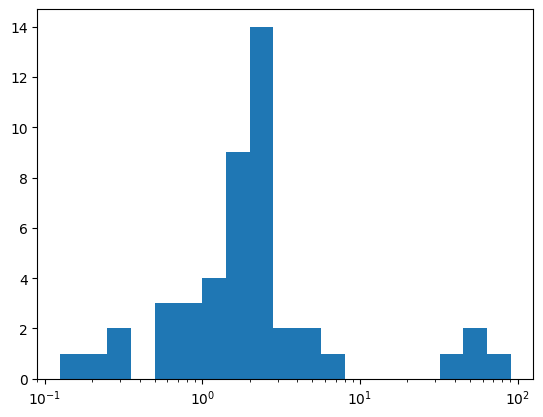

In [8]:
is_standing = (trace.control.sel(ctype="speed")==0).all(dim="bound")
tmp = np.r_[False,is_standing,False]
edges = np.flatnonzero(tmp[:-1] != tmp[1:]).reshape(-1,2)
t_standing = is_standing.ts[xa.DataArray(edges-[0,1],dims=("stop","bound"))]
dts = t_standing.sel(bound=1)-t_standing.sel(bound=0)
plt.hist(dts,bins=2**np.arange(-3,7,0.5))
plt.xscale("log")

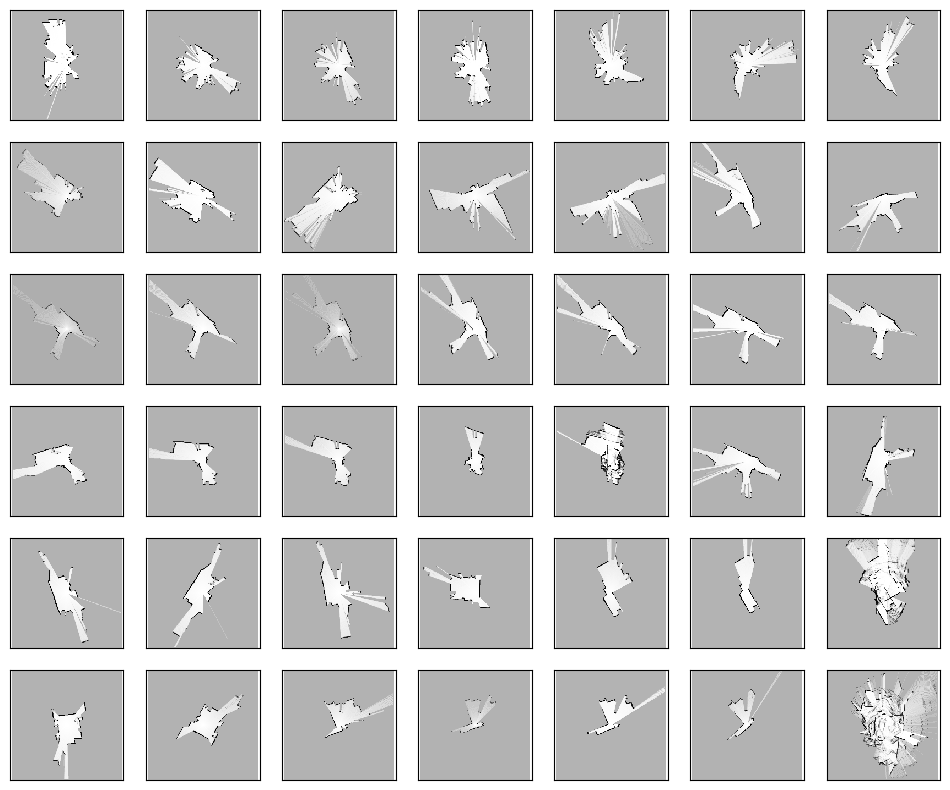

In [9]:
xsize = 10
ysize = 10
reso = 0.05

fig,axes = plt.subplots(6,7,figsize=(12,10))

for (s,e), ax in zip(edges[dts>0.2],axes.ravel()):
    batch = trace.isel(ts = np.s_[s+50:e])
    pos = np.zeros((batch.distance.size,2))
    
    positive, negative = render_lidar(
        shape = tuple((np.r_[ysize,xsize]/reso).astype(int)),
        pos = (pos + np.r_[xsize,ysize]/2)/reso,
        angle = batch.phi.values.ravel(),
        distance = batch.distance.values.ravel()/reso,
        nconf = np.where(batch.intensity.values.ravel()>0.1,0.2,0),
        pconf = np.where(batch.intensity.values.ravel()>0.1,batch.intensity.values.ravel(),0),
    )

    ax.pcolormesh((negative+0.7)/(negative+positive+1),cmap="gray")
    ax.axis("equal")
    ax.set_xticks([])
    ax.set_yticks([])

[]

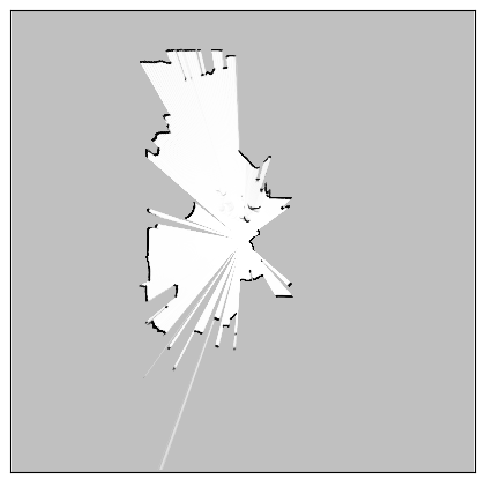

In [88]:
xsize = 10
ysize = 10
reso = 0.025

s,e = edges[0]
batch = trace.isel(ts = np.s_[s+50:e])
pos = np.zeros((batch.distance.size,2))

positive, negative = render_lidar(
    shape = tuple((np.r_[ysize,xsize]/reso).astype(int)),
    pos = (pos + np.r_[xsize,ysize]/2)/reso,
    angle = batch.phi.values.ravel(),
    distance = batch.distance.values.ravel()/reso,
    nconf = np.where(batch.intensity.values.ravel()>0.1,0.2,0),
    pconf = np.where(batch.intensity.values.ravel()>0.1,batch.intensity.values.ravel(),0),
)

fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.pcolormesh((negative+1.5)/(negative+positive+2),cmap="gray",vmin=0,vmax=1)
ax.axis("equal")
ax.set_xticks([])
ax.set_yticks([])

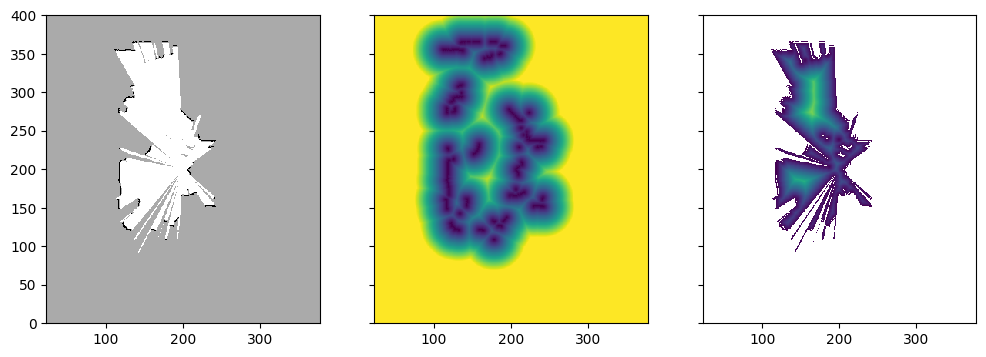

In [89]:
scale = negative+positive+2
known_blocked = (positive+0.5)>0.9*scale
known_free = (negative+1.5)>0.9*scale
known = known_blocked | known_free

distance_map_blocked = scipy.ndimage.distance_transform_edt(~known_blocked)
distance_map_free = scipy.ndimage.distance_transform_edt(known_free)

fig,axes = plt.subplots(1,3,figsize=(12,4),sharey=True)
ax = axes[0]
ax.pcolormesh(0.5*known_free-known_blocked,cmap="gray")

ax = axes[1]
ax.pcolormesh(distance_map_blocked,vmax=1/reso)

ax = axes[2]
ax.pcolormesh(np.where(known,distance_map_free,np.nan),vmax=1/reso)

for ax in axes:
    ax.axis("equal")

In [90]:
@numba.njit
def check_lidar_hit(pos, angle, distance, hitmap):
    """ Count cell hits using Bresenham's. """
    n = pos.shape[0]
    assert pos.shape == (n,2) # x,y
    assert angle.shape == (n,)
    assert distance.shape == (n,)
    shape = hitmap.shape

    ret = np.empty(n,np.bool_)

    fac = 4/np.pi
    ifac = np.pi/4
    for k in range(n):
        phi = angle[k]
        p = pos[k]
        d = distance[k]
        
        octant = int(np.floor(fac*phi))
        is_y = int(bool((octant+1)&2))
        main_neg = bool((octant+1)&4)
        sec_neg = bool((octant+0)&2) != main_neg

        c = abs(np.cos(phi))
        s = abs(np.sin(phi))
        mx = max(c,s)
        mn = min(c,s)
        m = (-mn if sec_neg else mn)/mx
        # the rest here works mostly in absolute major coordinates
        lim = shape[1-is_y]-1
        start = min(max(int(p[is_y]),0),lim)
        end = int(p[is_y] + (-d if main_neg else d)*mx)
        stop = min(max(end,0),lim)
        mad = -1 if main_neg else 1

        milim = shape[is_y]
        minor = (start+0.5-p[is_y])*m + p[1-is_y]
        did_hit = True
        for i in range(start,stop+mad,mad):
            j = int(minor)
            minor += m
            if not 0 <= j < milim:
                continue
            if is_y:
                if hitmap[i,j]:
                    break
            else:
                if hitmap[j,i]:
                    break
        else:
            did_hit = False
        ret[k] = did_hit

    return ret
        

In [91]:
def interpolate_distance_map(pos, angle, distance, distance_map_blocked, distance_map_free):
    p = pos
    phi = angle
    d = distance
    
    cs = jnp.cos(phi)
    sn = jnp.sin(phi)
    u = jnp.array([cs,sn])

    c = p + d*u - 0.5
    pi = c.astype(jnp.int32)
    i = jnp.clip(pi, 1, np.array(distance_map_blocked.shape[:2])-3)
    f = jnp.clip(c - i,0.,1.)
    g = 1 - f
    qf2 = 0.25*f**2
    qg2 = 0.25*g**2
    x,y = jnp.array([
        qg2,
        0.5-qf2,
        0.5-qg2,
        qf2,
    ]).T

    w = y[:,None]*x[None,:]
    vb = jax.lax.dynamic_slice(distance_map_blocked, i[::-1]-1, [4,4])
    db = (w*vb).sum() + jnp.abs(i-pi).sum()
    vf = jax.lax.dynamic_slice(distance_map_free, i[::-1]-1, [4,4])
    df = jnp.where(jnp.all(i == pi),(w*vf).sum(),0)
    return db,df

interpolate_distance_map = jax.vmap(
    interpolate_distance_map,
    in_axes = [0,0,0,None,None],
)

def sqaured_hit_error(pos, angle, distance, weight, is_blocked, distance_map_blocked, distance_map_free, min_weight):
    assert distance_map_blocked.shape == distance_map_free.shape
    
    d_blocked, d_free = interpolate_distance_map(pos, angle, distance, distance_map_blocked, distance_map_free)
    fw = weight * jnp.where(is_blocked, d_blocked, jnp.where(d_blocked>0,d_free/d_blocked,1))
    fws = fw.sum()
    ws = weight.sum()
    #  f*ws + (1-f)*fws = min_weight
    # -> f*(ws - fws) = min_weight - fws
    missing = min_weight-fws
    gain = ws - fws
    f = jnp.clip(jnp.where(gain>0,missing/gain,0),0,1)
    g = 1 - f
    d = g*jnp.where(is_blocked, d_blocked, d_free) + f*d_blocked
    w = g*fw + f*weight
    tw = (g*fws+f*ws)
    return (d**2*w).sum()/tw, tw, fws

sqaured_hit_error = jax.jit(sqaured_hit_error, backend="cpu", inline=True)

sqaured_hit_error

<PjitFunction of <function sqaured_hit_error at 0x342480c20>>

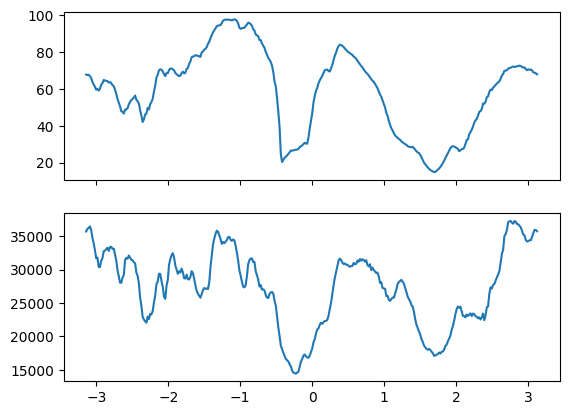

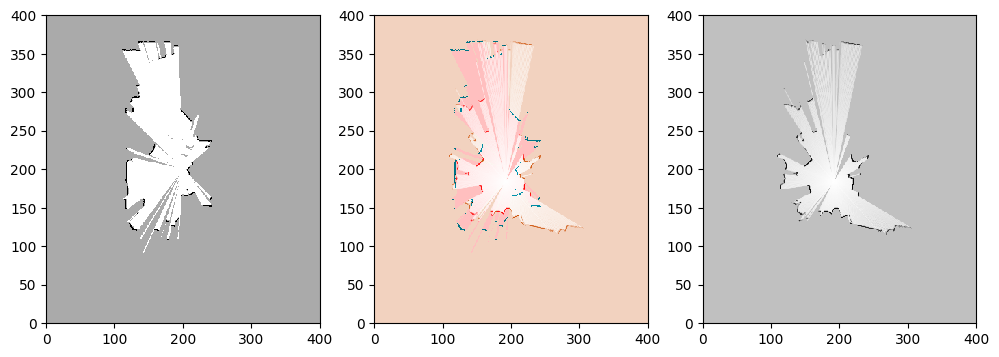

In [133]:
idx = np.flatnonzero(dts>0.2)[5]

s,e = edges[idx]
batch = trace.isel(ts = np.s_[s+10:e])

dpos = np.array({
    1:(-0.9,0),
    2:(-0.7,0.1),
    4:(-0.8,0.1),
    6:(-0.2,-.4),
}.get(idx,(0,0)))/reso
phi = np.linspace(-np.pi,np.pi,360,endpoint=False)
res = []
for p in phi:
    kw = dict(
        pos = np.tile(p0+dpos,(batch.phi.size,1)),
        angle = batch.phi.values.ravel() + p,
        distance = batch.distance.values.ravel()/reso,        
    )
    is_blocked = check_lidar_hit(
        **kw,
        hitmap = known_blocked,
    )
    res.append(sqaured_hit_error(
        **kw,
        weight = np.where(batch.intensity.values.ravel()>0.1,batch.intensity.values.ravel(),0),
        is_blocked = is_blocked,
        distance_map_blocked = distance_map_blocked,
        distance_map_free = distance_map_free,
        min_weight=16,
    ))
sqe, tw, fw = np.array(res).T

fig,axes = plt.subplots(2,1,sharex=True)
ax = axes[0]
ax.plot(phi,np.sqrt(sqe))
ax = axes[1]
ax.plot(phi,fw)

dphi = phi[np.argmin(sqe)]
dphi = 1.3

p0 = np.r_[xsize,ysize]/2/reso
p, n = render_lidar(
    shape = tuple((np.r_[ysize,xsize]/reso).astype(int)),
    pos = np.tile(p0+dpos,(batch.phi.size,1)),
    angle = batch.phi.values.ravel() + dphi,
    distance = batch.distance.values.ravel()/reso,
    nconf = np.where(batch.intensity.values.ravel()>0.1,0.2,0),
    pconf = np.where(batch.intensity.values.ravel()>0.1,batch.intensity.values.ravel(),0),
)


fig,axes = plt.subplots(1,3,figsize=(12,4),sharex=True)
ax = axes[0]
ax.pcolormesh(0.5*known_free-known_blocked,cmap="gray")
ax = axes[1]
base = ((n+1.5)/(n+p+2))[...,None]*[1,1,1]
overlay = np.where(known_free[...,None],base*[0,1,1]+[1,0,0],base*[0.2,0.7,1.0]+[0.8,0.3,0.0])
overlay = np.where(known_blocked[...,None],base*[0,0.6,0.7],overlay)
ax.pcolormesh(overlay)
ax = axes[2]
ax.pcolormesh((n+1.5)/(n+p+2),cmap="gray",vmin=0,vmax=1)



In [123]:
idx

6

In [83]:
def partial_model(param,p0,scan_angle,distance,weight,is_blocked,distance_map_blocked,distance_map_free):
    dpos = param[:2]
    dphi = param[2]
    sqe,_,_ = sqaured_hit_error(
        pos = jnp.tile(p0+dpos,(scan_angle.size,1)),
        angle = scan_angle + dphi,
        distance = distance,
        weight = weight,
        is_blocked = is_blocked,
        distance_map_blocked = distance_map_blocked,
        distance_map_free = distance_map_free,
        min_weight=16,
    )    
    return sqe
    
partial_model = jax.jit(partial_model, backend="cpu", inline=True)
partial_model_with_grad = jax.jit(jax.value_and_grad(partial_model), backend="cpu", inline=True)

In [84]:
p0 = np.r_[xsize,ysize]/2/reso

scan_angle = batch.phi.values.ravel()
distance = batch.distance.values.ravel()/reso       
weight = np.where(batch.intensity.values.ravel()>0.1,batch.intensity.values.ravel(),0)

def model(param):
    dpos = param[:2]
    dphi = param[2]
    is_blocked = check_lidar_hit(
        pos = np.tile(p0+dpos,(scan_angle.size,1)),
        angle = scan_angle + dphi,
        distance = distance,      
        hitmap = known_blocked,
    )
    return partial_model(
        param,
        p0,
        scan_angle,
        distance,
        weight,
        is_blocked,
        distance_map_blocked,
        distance_map_free,
    )

plim = 2/reso
optres = scipy.optimize.differential_evolution(
    model,
    bounds = [(-plim,plim),(-plim,plim),(1.5,2.5)],
)
optres

             message: Optimization terminated successfully.
             success: True
                 fun: 0.039263155311346054
                   x: [ 7.773e+01  7.284e+01  2.498e+00]
                 nit: 61
                nfev: 2794
          population: [[ 7.773e+01  7.284e+01  2.498e+00]
                       [ 7.788e+01  7.284e+01  2.476e+00]
                       ...
                       [ 7.799e+01  7.494e+01  2.490e+00]
                       [ 7.641e+01  7.696e+01  2.497e+00]]
 population_energies: [ 3.926e-02  3.948e-02 ...  4.014e-02  3.955e-02]

In [134]:
def quantify(param,startparam,p0,a0,n_samples):
    param = jnp.concatenate([param,startparam[None,:]],axis=0)
    speed = param[:,0,None]
    drift = param[:,1,None]
    curv = param[:,2,None]
    f = np.linspace(0,1,n_samples,endpoint=False)[::-1]
    g = 1-f
    speed = (f*speed[:-1]+g*speed[1:]).ravel()
    drift = (f*drift[:-1]+g*drift[1:]).ravel()
    curv = (f*curv[:-1]+g*curv[1:]).ravel()

    dphi = curv*speed
    dphi = dphi.at[0].add(a0)
    phi = jnp.cumsum(dphi)
    c = jnp.cos(phi)
    s = jnp.sin(phi)
    dp = (jnp.array([s,-c])*speed + jnp.array([-c,-s])*drift).T
    dp = dp.at[0].add(p0)
    pos = jnp.cumsum(dp,axis=0)
    return pos, phi

quantify = jax.jit(quantify, static_argnames=["n_samples"], backend="cpu", inline=True)
    

In [137]:
def partial_model(param,startparam,p0,a0,n_samples,scan_angle,distance,weight,is_blocked,distance_map_blocked,distance_map_free):
    pos, dphi = quantify(param,startparam,p0,a0,n_samples)

    sqe,_,_ = sqaured_hit_error(
        pos = pos,
        angle = scan_angle + dphi,
        distance = distance,
        weight = weight,
        is_blocked = is_blocked,
        distance_map_blocked = distance_map_blocked,
        distance_map_free = distance_map_free,
        min_weight=16,
    )    
    return sqe
    
partial_model = jax.jit(partial_model, static_argnames=["n_samples"], backend="cpu", inline=True)
partial_model_with_grad = jax.jit(jax.value_and_grad(partial_model),static_argnames=["n_samples"],backend="cpu", inline=True)

In [153]:
def model_with_grad(param,startparam,p0,a0,n_samples, scan_angle, distance, weight, known_blocked, distance_map_blocked, distance_map_free):
    pos, dphi = quantify(param,startparam,p0,a0,n_samples)
    is_blocked = check_lidar_hit(
        pos = np.array(pos),
        angle = scan_angle + np.array(dphi),
        distance = distance,      
        hitmap = known_blocked,
    )
    return partial_model_with_grad(
        param,
        startparam,
        p0,
        a0,
        n_samples,
        scan_angle,
        distance,
        weight,
        is_blocked,
        distance_map_blocked,
        distance_map_free,
    )

In [155]:
n = 512
m = 3

p0 = np.r_[xsize,ysize]/2/reso
a0 = 0

cur_param = np.array([[0.,0,0]]*m)
start_param = cur_param[0]

scan_angle = batch.phi.values.ravel()[:n*m]
distance = batch.distance.values.ravel()[:n*m]/reso       
weight = np.where(batch.intensity.values.ravel()>0.1,batch.intensity.values.ravel(),0)[:n*m]

model_with_grad(
    cur_param.reshape(m,3),
    scan_angle = scan_angle,
    distance = distance,
    weight = weight,
    startparam = start_param,
    p0 = p0,
    a0 = a0,
    n_samples = n,
    known_blocked = known_blocked,
    distance_map_blocked = distance_map_blocked,
    distance_map_free = distance_map_free,
)

(Array(9035.421, dtype=float32),
 Array([[-13399.808, -39838.258,      0.   ],
        [-22637.39 , -64599.   ,      0.   ],
        [-14882.869, -37151.41 ,      0.   ]], dtype=float32))

In [163]:
n = 512
m = 3

scan_angle = trace.phi.values.ravel()
scan_distance = trace.distance.values.ravel()
scan_intensity = trace.intensity.values.ravel()

cur_param = np.array([[0,0,0]]*m)
cur_pos = np.r_[xsize,ysize]/2/reso
cur_angle = 0

dt = 1/5000
maxspeed = 1*dt/reso
maxdrift = 0.1*dt/reso
minradius = 0.2/reso
maxcurv = 1/minradius

start_idx = edges[0][1]*12-n*50

pos = []
angle = []
match = []
localisations = []
for i in (pbar := tqdm.notebook.trange(start_idx,start_idx+100*n,n)):
    slc = np.s_[i:i+m*n]
    aa = scan_angle[slc]
    da = scan_distance[slc]/reso
    wa = np.where(scan_intensity[slc]>0.1,scan_intensity[slc],0)
    
    start_param = cur_param[0]
    x0 = np.concatenate([cur_param[1:],cur_param[-1:]],axis=0)*0
    optres = scipy.optimize.minimize(
        lambda p: ((res := model_with_grad(
            p.reshape(m,3),
            scan_angle = aa,
            distance = da,
            weight = wa,
            startparam = start_param,
            p0 = cur_pos,
            a0 = cur_angle,
            n_samples = n,
            known_blocked = known_blocked,
            distance_map_blocked = distance_map_blocked,
            distance_map_free = distance_map_free,
        ))[0],res[1].ravel()),
        x0.ravel(),
        method = "L-BFGS-B",
        jac = True,
        bounds = [(-maxspeed,maxspeed),(-maxdrift,maxdrift),(-maxcurv,maxcurv)]*m,
    )
    cur_param = optres.x.reshape(m,3)
    p,a = quantify(cur_param[:1],start_param,cur_pos,cur_angle,n_samples=n)
    cur_pos = p[-1]
    cur_angle = a[-1]
    pos.append(cur_pos)
    angle.append(cur_angle)
    match.append(optres.fun)
    localisations.append(dict(
        x = cur_pos[0]*reso,
        y = cur_pos[1]*reso,
        phi = cur_angle,
        match = optres.fun,
        speed = cur_param[0,0]*reso/dt,
        drift = cur_param[0,1]*reso/dt,
        curv = cur_param[0,2]/reso,
    ))
    pbar.set_postfix(pos=cur_pos,fun=optres.fun)
    print(optres.message)
pos = np.array(pos)
localisations = pd.DataFrame([{k:float(v) for k,v in d.items()} for d in localisations])
localisations

  0%|          | 0/100 [00:00<?, ?it/s]

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
ABNORMAL_TERMINATION_IN_LNSRCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
ABNORMAL_TERMINATION_IN_LNSRCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION

,x,y,phi,match,speed,drift,curv
0,4.999225,5.012571,-0.000006,2.128476,0.246004,0.015181,-0.000767
1,5.003821,5.067928,-0.007572,4.147518,0.836692,-0.100000,-0.231002
2,5.011869,5.098436,-0.013248,5.134154,-0.241530,-0.051004,-0.001984
3,5.019088,5.034889,-0.004873,5.512636,-1.000000,-0.100000,-0.218179
4,5.024746,4.983611,0.002593,4.702411,0.000675,-0.012216,0.000008
...,...,...,...,...,...,...,...
95,4.766115,4.569705,-3.262958,526.510498,0.841441,-0.089809,-4.302332
96,4.754644,4.538861,-3.371149,522.896606,-0.213603,-0.028682,0.007696
97,4.755737,4.550113,-3.371208,512.312500,-0.004831,-0.000483,0.000478
98,4.755981,4.551982,-3.371208,495.061798,-0.031859,-0.003186,0.000296


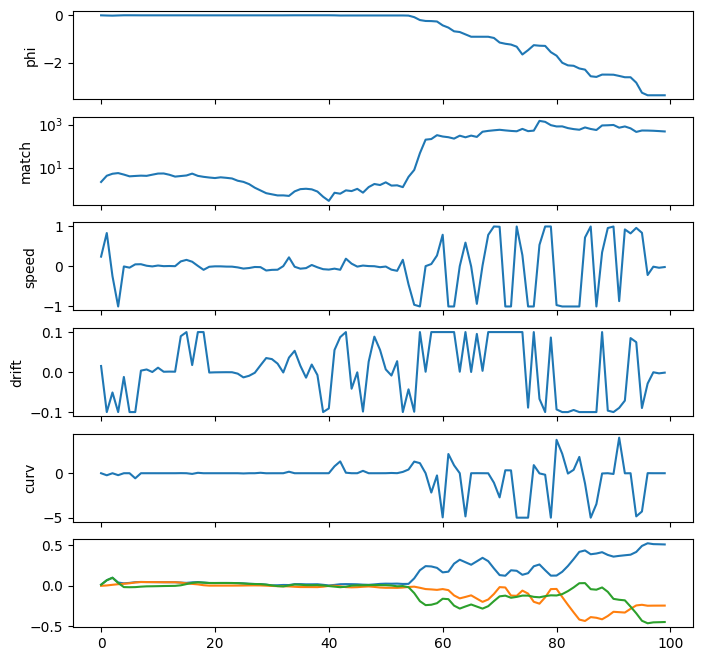

In [164]:
fig,axes = plt.subplots(6,1,figsize=(8,8),sharex=True)
for k,ax in zip(localisations.columns[2:],axes):
    ax.plot(localisations[k])
    ax.set_ylabel(k)
axes[1].set_yscale("log")
ax = axes[-1]
ax.plot(np.sqrt((localisations.x-xsize/2)**2+(localisations.y-ysize/2)**2))
ax.plot(localisations.x-xsize/2)
ax.plot(localisations.y-ysize/2)

In [ ]:
x,y = pos[:].T

fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.pcolormesh((negative+0.7)/(negative+positive+1),cmap="gray")
ax.plot(x,y)
ax.axis("equal")

In [ ]:
pos = np.zeros((batch.distance.size,2))

s = 3
wprob = scipy.ndimage.gaussian_filter(positive/(positive+negative+2),s)

pval = wprob
nval = wprob


value = np.array([pval,nval])
ysize,xsize = np.array(value.shape[1:])*reso

p = np.r_[0,0,0,0,0,0]
p0 = p[:2]
phi0 = p[2]*np.pi/180
dp = p[3:5]
dphi = p[5]*np.pi/180

phi = np.linspace(phi0,phi0+dphi,batch.phi.values.size)
pa = (pos + (np.r_[xsize,ysize]/2 + p0) + np.linspace(0,1,batch.phi.values.size)[:,None]*dp)/reso
aa = batch.phi.values.ravel()+(0.45-np.pi/2) + phi
da =  batch.distance.values.ravel()/reso

res = match_lidar_hit(
    pa,
    aa,
    da,
    pval,
#    startgap = 10,
#    endgap = 10,
#    step = 5,
)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax.pcolormesh(1-wprob,cmap="gray",vmin=0,vmax=1)
ax.axis("equal")

ax = fig.add_subplot(1,2,2, projection="polar")
plt.plot(aa, np.where(batch.intensity.values.ravel()>0.1,da,np.nan))


In [ ]:
res.shape

In [ ]:

da = batch.distance.values.ravel()/reso
wa = batch.intensity.values.ravel()
wpa = np.where(wa>0.1,1,0)
wna = np.where(wa>0.1,1/np.sqrt((da*reso)**2+1),0)
wpa = wna = wa
def model(p):
    p0 = p[:2]
    phi0 = p[2]*np.pi/180
    dp = p[3:5]
    dphi = p[5]*np.pi/180
    
    phi = np.linspace(phi0,phi0+dphi,batch.phi.values.size)
    pa = (pos + (np.r_[xsize,ysize]/2 + p0) + np.linspace(0,1,batch.phi.values.size)[:,None]*dp)/reso
    aa = batch.phi.values.ravel()+(0.45-np.pi/2) + phi
    
    res = match_lidar(
        pos = pa,
        angle = aa,
        distance = da,
        value = value,
        startgap = 10,
        endgap = 10,
        step = 1,
    )
    p,n = res.T
    p = p*wpa
    #n = np.expm1(-n)*wna
    return -p.mean()#, n.mean()


In [ ]:
optres = scipy.optimize.shgo(
    model,
    bounds = [(-1,1)]*2+[(-20,20)]+[(-0.5,0.0),(-0.0,0.0)]+[(-0,0)],
)
print(optres.x)
print(optres.message)

In [ ]:
#p = np.r_[0,0,-30,0.2,0,0]
p = optres.x

p0 = p[:2]
phi0 = p[2]*np.pi/180
dp = p[3:5]
dphi = p[5]*np.pi/180
print(f"{p0=} {dp=} {p[2]:.1f} {p[5]:.1f}")

pa = (pos + (np.r_[xsize,ysize]/2 + p0) + np.linspace(0,1,batch.phi.values.size)[:,None]*dp)/reso
phi = np.linspace(phi0,phi0+dphi,batch.phi.values.size)
aa = batch.phi.values.ravel()+(0.45-np.pi/2) + phi

p, n = render_lidar(
    shape = tuple((np.r_[ysize,xsize]/reso).astype(int)),
    pos = pa,
    angle = aa,
    distance = da,
    nconf = np.where(batch.intensity.values.ravel()>0.1,0.5,0),
    pconf = np.where(batch.intensity.values.ravel()>0.1,batch.intensity.values.ravel(),0),
)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.pcolormesh((n+0.7)/(n+p+1),cmap="gray")
ax.axis("equal")

In [ ]:
batch.ts[[0,-1]]